In [1]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset

2023-08-10 17:03:08.389634: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 17:03:08.544823: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-10 17:03:08.546133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 17:03:09.891791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]

files = getFiles('~/data/waymo/')

In [3]:
import tqdm
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: np.ndarray


def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


  0%|          | 0/100 [00:00<?, ?it/s]2023-08-10 17:03:18.669872: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-10 17:03:18.921805: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
 10%|█         | 10/100 [07:05<1:03:46, 42.52s/it]


KeyboardInterrupt: 

In [48]:
print("trajectories: ", len(h))
if len(h) > 0:
    lens = [len(x) for x in h]
    print("avg len: ", sum(lens)/len(lens))

trajectories:  325
avg len:  198.53846153846155


In [5]:
def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

for s in h[4]:
    err = normalize_angle(np.arctan2(s.velocity[1], s.velocity[0])- s.heading)**2
    print(s.velocity[0], s.velocity[1])
    print(np.arctan2(s.velocity[1], s.velocity[0]), s.heading)

-0.6033403 -0.29557413
-2.6860607 -2.685227394104004
-0.63066554 -0.31144542
-2.6828883 -2.6853933334350586
-0.6925942 -0.3451719
-2.6792455 -2.6853065490722656
-0.75051224 -0.36821628
-2.6854773 -2.685509204864502
-0.80487454 -0.39107856
-2.6892986 -2.6857566833496094
-0.8647316 -0.42277873
-2.6868536 -2.685789108276367
-0.9241577 -0.45644513
-2.6828337 -2.685671091079712
-0.9855256 -0.4867216
-2.682861 -2.6856818199157715
-1.0384393 -0.5009156
-2.6921453 -2.6858057975769043
-1.0500392 -0.5094217
-2.6898992 -2.685610055923462
-1.0415444 -0.51445305
-2.6828105 -2.6852898597717285
-1.0481974 -0.5140947
-2.6856093 -2.685591697692871
-1.0570596 -0.5136322
-2.6892834 -2.6861698627471924
-1.0585835 -0.51602805
-2.6880188 -2.6862194538116455
-1.0543981 -0.5163588
-2.6862035 -2.6857070922851562
-1.0561582 -0.5174523
-2.6860268 -2.6856772899627686
-1.057772 -0.5175353
-2.6865664 -2.6860313415527344
-1.0525867 -0.5155731
-2.686126 -2.686190605163574
-1.0435711 -0.5168889
-2.681706 -2.6860704421

In [49]:
import random
# convert into a dataset of tuples (state, next_state)
dataset = []
for states in h:
    for i in range(len(states)-1):
        if np.linalg.norm(states[i].velocity) > 0.2:
            dataset.append((states[i], states[i+1]))

# shuffle the dataset
#random.shuffle(dataset)

In [50]:
# dataset = [(h[0][0], h[0][1])] * 10000

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create an idm that attempts to predict: throttle and steering
# given state at current timestep, and state at next timestep:
# each state contains: velocity_x, velocity_y, and heading
class IDM(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 6, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 2) # Bx256 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx2
        return x



# How to train the Inverse Dynamics Model

An IDM (Inverse Dynamics Model) is a model that predicts the control input (steering angle and acceleration) given the current state of the vehicle and the next state of the vehicle. In RL parlance, we have $s_t$ and $s_{t+1}$ and we want to predict $a_t$.

We're training the IDM on the Waymo Motion Dataset. The dataset contains several thousand trajectories of vehicles driving in a variety of environments. The trajectories are sampled at 10Hz, and each sample contains the state of the vehicle (position, velocity, heading, etc.) and the environment (traffic lights, other vehicles, etc.). However, it does not contain the control input (steering angle and acceleration) of the vehicle. This is what we want to predict.

To do this, we'll leverage the Metadrive simulator. We reformulate the problem of predicting the action as a RL game where the model tries to take the action that will result in the next state in the simulator being as close as possible to the ground truth next state. The reward function is the negative of the distance between the predicted next state and the ground truth next state. We train the model using PPO. 

In [46]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

Observation: typing.TypeAlias = tuple[State, State]

def compute_loss(s_pred: State, s_true:State) -> float:
    """
    Computes the loss between the predicted state and the true state
    """
    vel_error = np.linalg.norm(s_pred.velocity - s_true.velocity) ** 2
    heading_error = normalize_angle(s_pred.heading - s_true.heading) ** 2
    return float(vel_error + heading_error)

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def run_game(env: MetaDriveEnv, policy:typing.Callable[[Observation], tuple[float, float]], o: Observation) -> tuple[tuple[float, float], float, State]:
    """
    runs the policy and returns the total reward
    """
    st0, st1 = o
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(1):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(st0.velocity)
    env.vehicle.set_heading_theta(st0.heading)
    
    # run the policy
    action = policy(o)
    env.step(action)

    # compute the reward
    st1_pred = get_metadrive_state(env)
    reward = -compute_loss(st1_pred, st1)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return action, reward, st1_pred

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)


def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

In [41]:
class PolicyNetwork(nn.Module):
    def __init__(self,):
        super().__init__()
        self.idm = IDM()

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        mu = self.idm(x)
        # sigma is fixed at 0.2
        sigma = 0.2*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

class NNPolicy:
    def __init__(self, net: PolicyNetwork):
        self.net = net

    def __call__(self, obs:Observation) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor).sample()[0]
        return steering.item(), throttle.item()

class IDMPolicy:
    def __init__(self, net: IDM):
        self.net = net

    def __call__(self, obs:Observation) -> tuple[float, float]:
        # sample an action from the policy network
        obs_tensor = obs_batch_to_tensor([obs], deviceof(self.net))
        # sample an action from the policy network
        with torch.no_grad():
            steering, throttle = self.net(obs_tensor)[0]
        return steering.item(), throttle.item()

def compute_policy_gradient_loss(
    # Current policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Rewards To Go for the chosen action
    # in (Batch,)
    R_t: torch.Tensor,
) -> torch.Tensor:
    """
    Computes the policy gradient loss for a vector of examples, and reduces with mean.
    """

    # in (Batch,)
    loss_per_example = -pi_theta_given_st.log_prob(a_t) * R_t

    return loss_per_example.mean()


def train_policygradient(
    policy_network: PolicyNetwork,
    policy_optimizer: torch.optim.Optimizer,
    observation_batch: list[tuple[State, State]],
    action_batch: list[tuple[float, float]],
    rew_batch: list[float],
) -> float:
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(rew_batch)

    # get device
    device = deviceof(policy_network)

    # convert data to tensors on correct device

    # in (Batch, C, H, W)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # in (Batch,)
    rew_batch_tensor = torch.tensor(
        rew_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # train policy
    policy_optimizer.zero_grad()
    action_probs = policy_network.forward(observation_batch_tensor)
    policy_loss = compute_policy_gradient_loss(
        action_probs, chosen_action_tensor, rew_batch_tensor
    )
    policy_loss.backward()
    policy_optimizer.step()

    # return the respective losses
    return policy_loss.item()

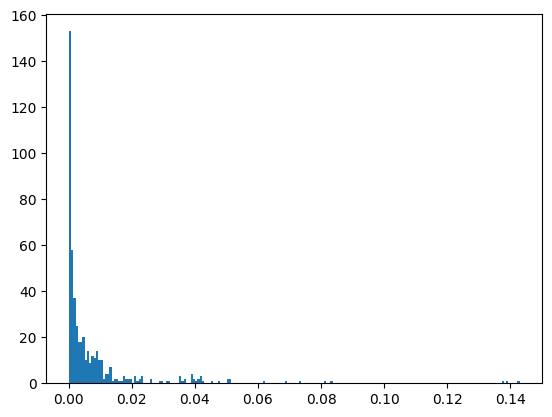

In [51]:
import matplotlib.pyplot as plt

dataset_diff_loss = []
# test loss function
for s0, s1 in dataset[:500]:
    dataset_diff_loss.append(compute_loss(s0, s1))

plt.hist(dataset_diff_loss, bins=200)
plt.show()

In [52]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy_network = PolicyNetwork()

policy_optimizer = torch.optim.Adam(policy_network.parameters())

dataset_iterator = iter(dataset)

step = 0
returns = []
losses = []

In [12]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [13]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": False})

In [53]:
# train idm model using metadrive as the ground truth
set_lr(policy_optimizer, 1e-5)
TRAIN_EPOCHS = 100
EPISODES_PER_BATCH = 1024

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[tuple[State, State]] = []
    act_batch:list[tuple[float, float]] = []
    rew_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        obs = next(dataset_iterator)
        # Collect trajectory
        action, reward, pred_state = run_game(env, NNPolicy(policy_network), obs)

        # Update batch
        obs_batch.append(obs)
        act_batch.append(action)
        rew_batch.append(reward)

        # Update trajectory returns
        trajectory_returns.append(reward)

    policy_loss = train_policygradient(
        policy_network,
        policy_optimizer,
        obs_batch,
        act_batch,
        rew_batch,
    )

    # collect statistics
    losses.append(policy_loss)
    returns.append(trajectory_returns)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Policy Loss: {losses[-1]:.3f}")

    step += 1

Step 0, Avg. Returns: -0.436 +/- 0.416, Median: -0.278, Policy Loss: -0.667
Step 1, Avg. Returns: -0.398 +/- 0.378, Median: -0.255, Policy Loss: -0.640
Step 2, Avg. Returns: -0.365 +/- 0.318, Median: -0.269, Policy Loss: -0.571
Step 3, Avg. Returns: -0.423 +/- 0.413, Median: -0.307, Policy Loss: -0.612
Step 4, Avg. Returns: -0.448 +/- 0.416, Median: -0.298, Policy Loss: -0.669
Step 5, Avg. Returns: -0.389 +/- 0.347, Median: -0.253, Policy Loss: -0.608


In [ ]:
env.close()

Let's try visualizing our IDM by having it follow a scenario from start to finish.

In [ ]:
env = gym.make("MetaDrive-validation-v0", config={"on_continuous_line_done": False, "use_render": True})

In [ ]:
scenario = h[5]
with torch.no_grad():
    # reset
    env.reset()

    # allow car to settle
    for _ in range(10):
        env.step([0,0])

    st = scenario[0]

    # set the initial state
    env.vehicle.set_velocity(st.velocity)
    env.vehicle.set_heading_theta(st.heading)


    for i in range(len(scenario)-1):
        st0 = scenario[i]
        st1 = scenario[i+1]
        action = IDMPolicy(policy_network.idm)((st0, st1))
        print(action)
        env.step(action)
        pred_st1 = pred_state
        print(compute_loss(st1, pred_st1))

        

[array([[ 1.21904925e+01,  1.21208021e+01],
       [-1.40600442e-01, -2.01223411e-01],
       [ 0.00000000e+00, -9.20742750e-03]])]
(1.0040955543518066, 0.4074711799621582)
0.17714485681455253
[array([[ 1.21221410e+01,  1.19941314e+01],
       [-8.96150518e-02, -1.96125988e-01],
       [ 0.00000000e+00, -8.92359018e-03]])]
(0.9960189461708069, 0.4041087329387665)
1.0746742559826825
[array([[ 1.19954040e+01,  1.18866286e+01],
       [-8.90888866e-02, -1.81910255e-01],
       [ 0.00000000e+00, -8.65960121e-03]])]
(0.9889030456542969, 0.40001457929611206)
3.6933329971038624
[array([[ 1.18877581e+01,  1.17771129e+01],
       [-7.89712579e-02, -1.79556032e-01],
       [ 0.00000000e+00, -8.46427679e-03]])]
(0.9811077117919922, 0.39629918336868286)
10.55198861066661
[array([[ 1.17782108e+01,  1.16637056e+01],
       [-7.98660474e-02, -1.82392563e-01],
       [ 0.00000000e+00, -8.54468346e-03]])]
(0.9723333716392517, 0.39258456230163574)
24.185926578821732
[array([[ 1.16648383e+01,  1.15473685

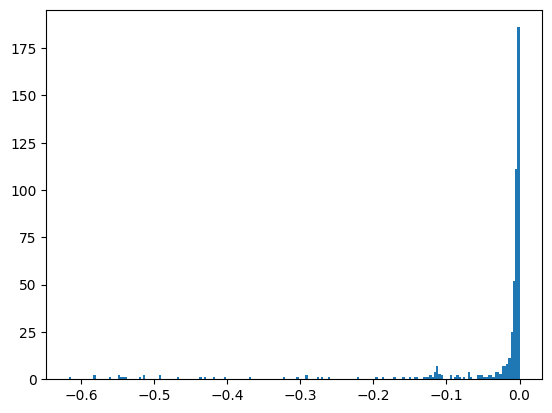

-0.03994238112434515
-0.004717607179241471


In [38]:
def null_policy(_:Observation) -> tuple[float, float]:
    return 0, 0


# test loss function
do_nothing_loss = []
for s0, s1 in dataset[:500]:
    _, rew, _ = run_game(env, null_policy, (s0, s1))
    do_nothing_loss.append(rew)

plt.hist(do_nothing_loss, bins=200)
plt.show()
print("mean", np.mean(do_nothing_loss))
print("median", np.median(do_nothing_loss))

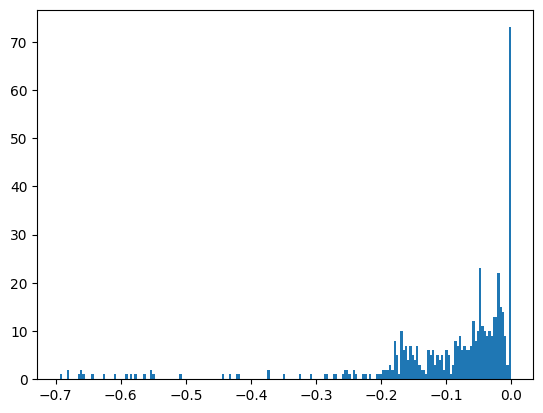

-0.09706552218027241
-0.05464064950272159


In [40]:

# test loss function
idm_loss = []
for s0, s1 in dataset[:500]:
    _, rew, _ = run_game(env, IDMPolicy(policy_network.idm), (s0, s1))
    idm_loss.append(rew)

plt.hist(idm_loss, bins=200)
plt.show()
print(np.mean(idm_loss))
print(np.median(idm_loss))

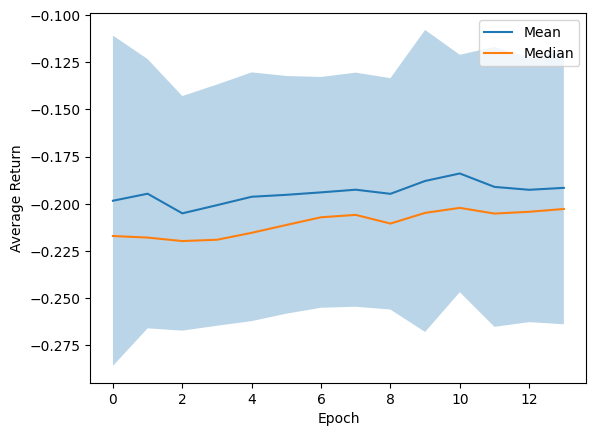

In [17]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_means, label="Mean")
plt.plot(return_medians, label="Median")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

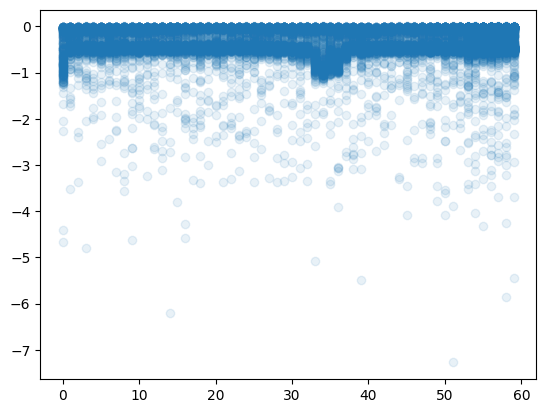

In [ ]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.1)